# Initialise main directory


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
main_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls '{main_dir}'/.

Mounted at /content/gdrive
All_Data  Csv_Files	 Helper_Notebooks  Models
Audios	  Documentation  Main_Notebooks


# Install and import libraries

In [2]:
!pip install -q librosa
!pip install -q pysoundfile
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.6 MB/s 


In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf

import keras_tuner as kt
from ast import literal_eval
from joblib import dump, load

import os
import sys
import time

%matplotlib inline

import urllib.request as urllib2 # For python3
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import librosa
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from PIL import Image
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Obtain features and labels


In [4]:
label_target = {('baritone_bassbaritones', 0), ('baritone_dramatic', 1), ('baritone_lyric', 2), 
                ('tenor_spinto', 8), ('bass_dramatic', 4), ('bass_cantante', 3), ('tenor_leggero', 6), 
                ('tenor_lyric', 7), ('tenor_dramatic', 5)}
labels = [item[0] for item in label_target]
print(label_target)
print(labels)

def targets_to_labels(list_to_convert):
  labels=[]
  for item in list_to_convert:
    for label, target in label_target:
      if item == target:
        labels.append(label)
  return labels

#function for removing problematic classes
def remove_problematic(to_remove, processed_data):
  for subregister in to_remove:
    for label, target in label_target:
      if subregister==label:
        processed_data = processed_data[processed_data['class_label'] != target]
  return processed_data

{('baritone_lyric', 2), ('baritone_bassbaritones', 0), ('tenor_lyric', 7), ('tenor_dramatic', 5), ('bass_dramatic', 4), ('bass_cantante', 3), ('tenor_spinto', 8), ('baritone_dramatic', 1), ('tenor_leggero', 6)}
['baritone_lyric', 'baritone_bassbaritones', 'tenor_lyric', 'tenor_dramatic', 'bass_dramatic', 'bass_cantante', 'tenor_spinto', 'baritone_dramatic', 'tenor_leggero']


In [5]:
#read from mfccs data
processed_data = pd.read_csv(main_dir + "Csv_Files/males_mfccs.csv")
processed_data = processed_data.sample(frac=1)

# other_notebook = ['tenor_lyric', 'bass_dramatic', 'baritone_dramatic', 'tenor_dramatic']
# to_delete =====>  'baritone_bassbaritones', 'tenor_spinto'
to_evaluate = ['bass_cantante', 'tenor_leggero', 'baritone_lyric', 'baritone_bassbaritones']

to_remove = [item for item in labels if item not in to_evaluate]

processed_data = remove_problematic(to_remove, processed_data)
features = [literal_eval(processed_data['mfccs'].tolist()[i]) for i in range(len(processed_data))]
targets = processed_data["class_label"].tolist()
num_labels = len(set(targets))
print('Selected targets: ', set(targets))
print('Number of classes: ', num_labels )
print('To evaluate: ', to_evaluate)
print('Not considered: ', to_remove)

Selected targets:  {0, 2, 3, 6}
Number of classes:  4
To evaluate:  ['bass_cantante', 'tenor_leggero', 'baritone_lyric', 'baritone_bassbaritones']
Not considered:  ['tenor_lyric', 'tenor_dramatic', 'bass_dramatic', 'tenor_spinto', 'baritone_dramatic']


In [19]:
# processed_data.head()
lol = pd.read_csv(main_dir + "Csv_Files/males_mfccs.csv")
# lol.head()
for i in range(9):
  for label, target in label_target:
    if target==i:
      print(label,':  ', list(lol['class_label']).count(i))

baritone_bassbaritones :   360
baritone_dramatic :   452
baritone_lyric :   462
bass_cantante :   382
bass_dramatic :   382
tenor_dramatic :   472
tenor_leggero :   455
tenor_lyric :   458
tenor_spinto :   466


# Creating PCA components


Components 	 Fraction of explained variance
	 1 	 0.5651530683858182
	 2 	 0.6702283788724772
	 3 	 0.7344856780862545
	 4 	 0.7857540206175557
	 5 	 0.8191862861578393
	 10 	 0.907382862353719
	 20 	 0.9737901394763782
	 25 	 0.9843464559957303
	 28 	 0.9885110953174229
	 30 	 0.9904817566984817
	 32 	 0.9920171763447089
	 40 	 0.9959303129667901
	 50 	 0.9981584112478786




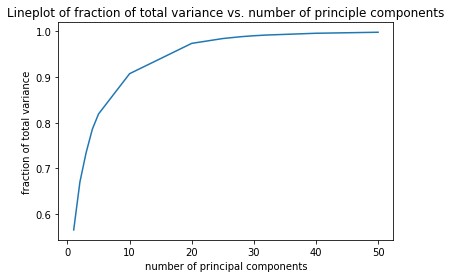

In [ ]:
def get_pca_components(data):
  k = [1, 2, 3, 4, 5, 10, 20, 25, 28, 30, 32, 40, 50]
  explained_variances = []
  print('Components \t Fraction of explained variance')
  for components in k:
    pca = PCA(n_components = components)
    data_pc = pca.fit_transform(data)
    fraction_of_variance = sum(pca.explained_variance_ratio_)
    print('\t',components,'\t',fraction_of_variance)
    explained_variances.append(fraction_of_variance)
  print('\n')
  plt.plot(k, explained_variances)
  plt.xlabel("number of principal components")
  plt.ylabel("fraction of total variance")
  plt.title("Lineplot of fraction of total variance vs. number of principle components")
  plt.show()
  pass

get_pca_components(data = features)

# Train_Test_Split

In [ ]:
components = 32
pca = PCA(n_components = components)
data_pca = pca.fit_transform(features)
dump(pca, main_dir + 'Models/Development/Males_B/PCA/Males_B_pca.joblib') 
print( data_pca[2])
print(data_pca.shape)


[  5.27210204  47.16783094  -2.67745908  -2.66084276 -38.18983187
 -26.67608761   2.7230051  -21.3734083    6.82439613  -9.37963291
  -4.07910742   7.60111933   6.47258721  -5.65542398  -2.54248641
   9.67811913  -9.25203218  -0.83523319   7.83738664  15.15900589
   4.70512457   1.98984758   7.14955579  -3.43674923   2.60556082
   0.81403682   0.33527396   1.87699239   2.68714424  -2.34341944
  -0.31385834  -1.70683366]
(1659, 32)


In [ ]:
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(data_pca)
dump(standard_scaler, main_dir + 'Models/Development/Males_B/Scaler/Males_B_scaler.joblib')
X = np.array(X)
y = np.array(targets)
y_encoded = LabelEncoder().fit_transform(y)
y_categorical = to_categorical(y_encoded)

mapping = list(set([item for item in zip(y_encoded, targets)]))
label_mapping = {}
for item in mapping:
  label_mapping[int(item[0])] = item[1]

dump(label_mapping, main_dir +  'Models/Development/Males_B/Reports/Males_B_label_mapping.joblib')

x_train, x_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.15)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size = 0.18)

print('x_train: ',len(x_train))
print('y_train: ', len(y_train))
print('x_test: ',len(x_test))
print('y_test: ',len(y_test))
print('x_dev: ',len(x_dev))
print('y_dev: ',len(y_dev))

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Development/Males_B/Data/{0}/Males_B_{1}.csv'.format(folder, dataset_name), index=False)

# print('Datasets used saved')

x_train:  1156
y_train:  1156
x_test:  249
y_test:  249
x_dev:  254
y_dev:  254


# Keras Tuner

In [ ]:
def model_builder(hp):
  lower = 32
  upper = 156
  step = 4

  #input layer
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  

  hp_units_1 = hp.Int('units_1', min_value=lower, max_value=upper, step=step)
  hp_reg_1 = hp.Float('regs_1', min_value=0.001, max_value=0.1, step=0.001)
  hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.8, step=0.001)
  model.add(keras.layers.Dense(units=hp_units_1, activation='relu',
                               kernel_regularizer = regularizers.l2(hp_reg_1), name='dense_1'))
  model.add(keras.layers.Dropout(hp_dropout_1))

  
  hp_units_2 = hp.Int('units_2', min_value=lower, max_value=upper, step=step)
  hp_reg_2 = hp.Float('regs_2', min_value=0.001, max_value=0.1, step=0.001)
  hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.8, step=0.001)
  model.add(keras.layers.Dense(units=hp_units_2, activation='relu',
                               kernel_regularizer = regularizers.l2(hp_reg_2), name='dense_2'))
  model.add(keras.layers.Dropout(hp_dropout_2))

  # hp_units_3 = hp.Int('units_3', min_value=lower, max_value=upper, step=step)
  # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.1, step=0.001)
  # hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.8, step=0.001)
  # model.add(keras.layers.Dense(units=hp_units_3, activation='relu',
  #                              kernel_regularizer = regularizers.l2(hp_reg_3), name='dense_3'))
  # model.add(keras.layers.Dropout(hp_dropout_3))

  hp_units_4 = hp.Int('units_4', min_value=lower, max_value=upper, step=step)
  # hp_reg_3 = hp.Float('regs_3', min_value=0.001, max_value=0.1, step=0.001)
  # hp_dropout_3 = hp.Float('dropout_3', min_value=0.1, max_value=0.8, step=0.01)
  model.add(keras.layers.Dense(units=hp_units_4, activation='relu', name='dense_4'))
  # model.add(keras.layers.Dropout(hp_dropout_3))


  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))

  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  hp_learning_rate = 0.001

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model

In [ ]:

tuner_dir = main_dir + 'Main_Notebooks/Keras_Tuner_Approach/Males_Trials/Keras_Tuner/Males_B'
if os.path.exists(tuner_dir)==False:
  !mkdir "{tuner_dir}"

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=110,
                     factor=4,
                     directory=tuner_dir,
                     project_name='mk5')
print(tuner_dir)
print(tuner.project_name)

/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Main_Notebooks/Keras_Tuner_Approach/Males_Trials/Keras_Tuner/Males_B
mk5


In [ ]:
!ls "{tuner_dir}"

mk0  mk1  mk2  mk3  mk4  mk5


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 156, 'step': 4, 'sampling': None}
regs_1 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.001, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.001, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 156, 'step': 4, 'sampling': None}
regs_2 (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.1, 'step': 0.001, 'sampling': None}
dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.8, 'step': 0.001, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 156, 'step': 4, 'sampling': None}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [ ]:
tuner.search(x_train, y_train, epochs=180, validation_data=(x_dev, y_dev), callbacks=[stop_early])

Trial 161 Complete [00h 00m 05s]
val_accuracy: 0.8291457295417786

Best val_accuracy So Far: 0.8643215894699097
Total elapsed time: 00h 07m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]


In [ ]:
print('Layer1 units:', best_hps.get('units_1'))
print('Layer1 l2 regularizer:', best_hps.get('regs_1'))
print('Layer1 dropout:', best_hps.get('dropout_1'))

print('Layer2 units:', best_hps.get('units_2'))
print('Layer2 l2 regularizer:', best_hps.get('regs_2'))
print('Layer2 dropout:', best_hps.get('dropout_2'))

# print('Layer3 units:', best_hps.get('units_3'))
# print('Layer3 l2 regularizer:', best_hps.get('regs_3'))
# print('Layer3 dropout:', best_hps.get('dropout_3'))

print('Layer4 units:', best_hps.get('units_4'))



# print('Learning Rate:', best_hps.get('learning_rate'))

Layer1 units: 124
Layer1 l2 regularizer: 0.059000000000000004
Layer1 dropout: 0.13100000000000003
Layer2 units: 148
Layer2 l2 regularizer: 0.010000000000000002
Layer2 dropout: 0.6530000000000005
Layer4 units: 108


In [ ]:
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 124)               4092      
                                                                 
 dropout_2 (Dropout)         (None, 124)               0         
                                                                 
 dense_2 (Dense)             (None, 148)               18500     
                                                                 
 dropout_3 (Dropout)         (None, 148)               0         
                                                                 
 dense_4 (Dense)             (None, 108)               16092     
                                                                 
 output_layer (Dense)        (None, 3)                 327       
                                                                 
Total params: 39,011
Trainable params: 39,011
Non-trai

In [ ]:
h_history = h_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=180)

Epoch 1/180
29/29 [==============================] - 1s 13ms/step - loss: 4.8961 - accuracy: 0.4099 - val_loss: 4.2117 - val_accuracy: 0.5829
Epoch 2/180
29/29 [==============================] - 0s 5ms/step - loss: 3.7524 - accuracy: 0.5547 - val_loss: 3.2508 - val_accuracy: 0.6583
Epoch 3/180
29/29 [==============================] - 0s 5ms/step - loss: 2.8864 - accuracy: 0.6641 - val_loss: 2.5057 - val_accuracy: 0.7035
Epoch 4/180
29/29 [==============================] - 0s 4ms/step - loss: 2.2219 - accuracy: 0.7138 - val_loss: 1.9613 - val_accuracy: 0.7337
Epoch 5/180
29/29 [==============================] - 0s 4ms/step - loss: 1.7629 - accuracy: 0.7580 - val_loss: 1.5942 - val_accuracy: 0.7538
Epoch 6/180
29/29 [==============================] - 0s 5ms/step - loss: 1.4320 - accuracy: 0.8011 - val_loss: 1.3639 - val_accuracy: 0.7889
Epoch 7/180
29/29 [==============================] - 0s 5ms/step - loss: 1.1959 - accuracy: 0.8365 - val_loss: 1.1934 - val_accuracy: 0.7889
Epoch 8/180


# Manual model build

In [ ]:
def manual_model_builder():

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(components), dtype=tf.float32,
                          name='input_embedding'))
  
  model.add(keras.layers.Dense(units=88, activation='relu', name='dense_1', kernel_regularizer=regularizers.l2(0.024) ))
  model.add(keras.layers.Dropout(0.45))

  model.add(keras.layers.Dense(units=66, activation='relu', name='dense_2', kernel_regularizer=regularizers.l2(0.025)))
  model.add(keras.layers.Dropout(0.48))

  model.add(keras.layers.Dense(units=46, activation='relu', name='dense_3'))
  # model.add(keras.layers.Dropout(0.3))
  # , kernel_regularizer=regularizers.l2(0.002)

  #Output_Layer
  model.add(keras.layers.Dense(num_labels, activation='softmax', name='output_layer'))
  hp_learning_rate = 0.0005

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model


manual_model = manual_model_builder()
manual_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 88)                2904      
                                                                 
 dropout_56 (Dropout)        (None, 88)                0         
                                                                 
 dense_2 (Dense)             (None, 66)                5874      
                                                                 
 dropout_57 (Dropout)        (None, 66)                0         
                                                                 
 dense_3 (Dense)             (None, 46)                3082      
                                                                 
 output_layer (Dense)        (None, 4)                 188       
                                                                 
Total params: 12,048
Trainable params: 12,048
Non-tra

In [ ]:
manual_history = manual_model.fit(x_train, y_train, validation_data=(x_dev, y_dev), epochs=160)

Epoch 1/160
37/37 [==============================] - 1s 13ms/step - loss: 4.2828 - accuracy: 0.2535 - val_loss: 3.9913 - val_accuracy: 0.2835
Epoch 2/160
37/37 [==============================] - 0s 6ms/step - loss: 3.8632 - accuracy: 0.2794 - val_loss: 3.6477 - val_accuracy: 0.3071
Epoch 3/160
37/37 [==============================] - 0s 5ms/step - loss: 3.5304 - accuracy: 0.3080 - val_loss: 3.3412 - val_accuracy: 0.3701
Epoch 4/160
37/37 [==============================] - 0s 4ms/step - loss: 3.2383 - accuracy: 0.3339 - val_loss: 3.0673 - val_accuracy: 0.3976
Epoch 5/160
37/37 [==============================] - 0s 3ms/step - loss: 2.9640 - accuracy: 0.3728 - val_loss: 2.8213 - val_accuracy: 0.4173
Epoch 6/160
37/37 [==============================] - 0s 4ms/step - loss: 2.7295 - accuracy: 0.3919 - val_loss: 2.5955 - val_accuracy: 0.4882
Epoch 7/160
37/37 [==============================] - 0s 4ms/step - loss: 2.5171 - accuracy: 0.4308 - val_loss: 2.3875 - val_accuracy: 0.5157
Epoch 8/160


# Model and history selection

In [ ]:
model = manual_model
history = manual_history

# model = h_model
# history = h_history

# Model Performance and analysis

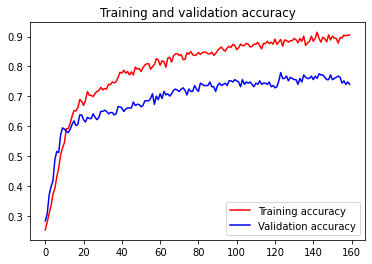

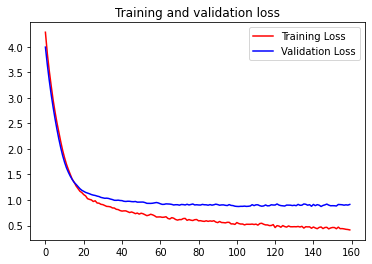

In [ ]:
def model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  
  plt.legend()
  plt.show()
  pass

model_performance(history)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)


8/8 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.8273
Test Loss:  0.5951957106590271
Test Accuracy:  0.827309250831604


                        precision    recall  f1-score   support

baritone_bassbaritones       0.85      0.76      0.80        54
        baritone_lyric       0.79      0.78      0.79        69
         bass_cantante       0.75      0.87      0.80        52
         tenor_leggero       0.90      0.89      0.90        74

              accuracy                           0.83       249
             macro avg       0.83      0.82      0.82       249
          weighted avg       0.83      0.83      0.83       249

[0.95745489 0.94355878 0.9719836  0.98664093]
0.9649095484382029


['/content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Males_B/Reports/Males_B_performance_report.joblib']

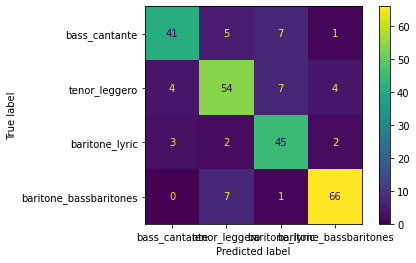

In [ ]:
y_pred = model.predict(x_test)
y_pred_list = [y_pred[i].argmax() for i in range(len(x_test))]
y_true_list = [y_test[i].argmax() for i in range(len(x_test))]

label_mapping = load(main_dir +  'Models/Development/Males_B/Reports/Males_B_label_mapping.joblib')

y_pred_list = [label_mapping[item] for item in y_pred_list]
y_true_list = [label_mapping[item] for item in y_true_list]

true_labels = targets_to_labels(y_true_list)
pred_labels = targets_to_labels(y_pred_list)


conf_matrix = metrics.confusion_matrix(true_labels, pred_labels)
cm = metrics.ConfusionMatrixDisplay(conf_matrix, display_labels=to_evaluate).plot()
precision, recall, f_score, _ = metrics.precision_recall_fscore_support(y_true_list, y_pred_list, average='macro')
con_mat_norm = np.around(conf_matrix.astype('int') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

performance_report = {}
performance_report['precision'] = precision
performance_report['recall'] = recall
performance_report['f_score'] = f_score
performance_report['conf_matrix'] = conf_matrix
performance_report['classification_report'] = metrics.classification_report(true_labels,pred_labels)
performance_report['avg_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, multi_class='ovr')
performance_report['spcfc_roc_auc_score'] = metrics.roc_auc_score(y_test,y_pred, average=None ,multi_class='ovr')

print(performance_report['classification_report'])
print(performance_report['spcfc_roc_auc_score'])
print(performance_report['avg_roc_auc_score'])
dump(performance_report, main_dir +  'Models/Development/Males_B/Reports/Males_B_performance_report.joblib')


In [ ]:
model.save(main_dir + 'Models/Development/Males_B/ANN/Males_B')
print('Males_B Model saved successfully')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Development/Males_B/ANN/Males_B/assets
Males_B Model saved successfully


# Save To Production


In [ ]:
# Saving the acceptable model

dump(pca, main_dir + 'Models/Production/Males_B/PCA/Males_B_pca.joblib')
print('pca model saved')
dump(standard_scaler, main_dir + 'Models/Production/Males_B/Scaler/Males_B_scaler.joblib')
print('scaler model saved')
model.save(main_dir + 'Models/Production/Males_B/ANN/Males_B')
print('ANN model saved')
dump(label_mapping, main_dir +  'Models/Production/Males_B/Reports/Males_B_label_mapping.joblib')
print('Label mapping saved')
dump(performance_report, main_dir +  'Models/Production/Males_B/Reports/Males_B_performance_report.joblib')
print('Performance report saved')

datasets = [x_train, y_train, x_test, y_test, x_dev, y_dev]
dataset_names = ['x_train', 'y_train', 'x_test', 'y_test', 'x_dev', 'y_dev']
for dataset, dataset_name in zip(datasets, dataset_names):
  df = pd.DataFrame(dataset)
  folder = dataset_name.split('_')[1].capitalize()
  df.to_csv(main_dir + 'Models/Production/Males_B/Data/{0}/Males_B_{1}.csv'.format(folder, dataset_name), index=False)

print('Datasets used saved')

pca model saved
scaler model saved
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/UpworkNotebooks/Opera Files/Models/Production/Males_B/ANN/Males_B/assets
ANN model saved
Label mapping saved
Performance report saved
Datasets used saved
